In [1]:
import os
import glob
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TOGETHER_API_KEY"] = os.getenv("TOGETHER_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [2]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_PROJECT"]="Agentc RAG"

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [5]:
from langchain_mistralai.embeddings import MistralAIEmbeddings
embeddings = MistralAIEmbeddings(model="mistral-embed") 

In [6]:
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document

In [7]:
all_text = ""
for file_path in glob.glob("Curie_Radiation_Documents/*.txt"):
    loader = TextLoader(file_path)
    docs = loader.load()
    for doc in docs:
        all_text += doc.page_content + "\n"

# Create a single Document object
combined_doc = Document(page_content=all_text)

# If you need it in a list format (e.g., for chains or vector stores)
docs = [combined_doc]

In [8]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(docs)
docs_string = [doc.page_content for doc in chunks]

In [9]:
vectorstore = Chroma.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [10]:
retriever.get_relevant_documents("What did Marie Curie got Nobel Price For?")

C:\Users\abhes\AppData\Local\Temp\ipykernel_15776\673820268.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("What did Marie Curie got Nobel Price For?")


[Document(metadata={}, page_content='She moved to Paris to study at the Sorbonne and met her husband, Pierre Curie, there. \nTogether, they conducted groundbreaking research on radioactivity. \nMarie was the first woman to win a Nobel Prize and the only person to win Nobel Prizes in two different scientific fields.\nHer dedication to science paved the way for women in STEM. \nShe named the element polonium after her homeland. \nHer early education took place under oppressive Russian rule, which suppressed Polish culture.'),
 Document(metadata={}, page_content="Curieâ€™s contribution was vital in integrating science into medicine.\nHer mobile X-ray vans in WWI are considered a revolutionary innovation.\nToday, nuclear medicine relies on her foundational research.\nShe set a precedent for using scientific discovery to benefit humanity.\nCurie's legacy lives on in hospitals and treatment centers worldwide.\nMarie Curie received the Nobel Prize in Physics in 1903, shared with Pierre Curie 

In [13]:
from typing_extensions import Annotated, Sequence, TypedDict
from langchain_core.messages import AnyMessage, BaseMessage 
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage] , add_messages]

In [14]:
from pydantic import BaseModel, Field
class TopicSelection(BaseModel):
    Topic: str = Field(description="The topic to select for the RAG process.")
    Reasoning: str = Field(description="The reasoning behind the topic selection.")

In [16]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelection)

In [59]:
from langchain_core.prompts import PromptTemplate
def LLMAgent(state : State):
    message = state["messages"]
    
    # Extract the content from the last message
    if isinstance(message[-1], str):
        question = message[-1]
    else:
        question = message[-1].content if hasattr(message[-1], 'content') else str(message[-1])
    
    template = """Your Task is to provide the brief answer based on the user query .
    Only respond with the topic and reasoning behind the topic selection.

    User Query: {question}
    {format_instructions}
    """
    prompt = PromptTemplate(template=template, 
        input_variables=[question], 
        partial_variables={"format_instructions": parser.get_format_instructions()})

    chain = prompt | llm | parser

    response = chain.invoke({"question": question, "format_instructions": parser.get_format_instructions()})

    print(response)
    
    return {"messages": [response.Topic]}

In [60]:
def router(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    
    if "Marie Curie" in str(last_message) or "Nobel" in str(last_message):
        return "Rag Call"
    else:
        return "LLM Call"

In [61]:
def RAGChain(state : State):
    message = state["messages"]
    
    # Extract the first message (original question)
    if isinstance(message[0], str):
        question = message[0]
    else:
        question = message[0].content if hasattr(message[0], 'content') else str(message[0])
    
    template = """Answer the question based on the following context:
    {context}
    
    Question: {question} 
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    response = chain.invoke(question)
    
    # Add the RAG response to the messages
    return {"messages": [response]}

In [62]:
def LLMChain(state: State):
    message = state["messages"]
    
    # Extract the content from the last message
    if isinstance(message[-1], str):
        question = message[-1]
    else:
        question = message[-1].content if hasattr(message[-1], 'content') else str(message[-1])
    
    query = "Answer the question based on the knowledge you have about the question " + question

    response = llm.invoke(query)

    return {"messages": [response.content]}

In [63]:
from langgraph.graph import StateGraph, END, START
graph = StateGraph(State)

graph.add_node("Agent", LLMAgent)
graph.add_node("Rag Chain", RAGChain)
graph.add_node("LLM Chain", LLMChain)

graph.set_entry_point("Agent")

graph.add_conditional_edges(
    "Agent",
    clean_router,
    {
        "Rag Call": "Rag Chain",
        "LLM Call": "LLM Chain"
    }
)

graph.add_edge("Rag Chain", END)
graph.add_edge("LLM Chain", END)

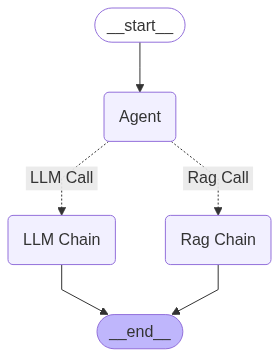

In [64]:
builder = graph.compile()
builder

In [65]:
query = {"messages": ["What did Marie Curie got Nobel Price For?"]}
response = builder.invoke(query)
print(response)

Topic="Marie Curie's Nobel Prizes" Reasoning='The user is asking about the specific Nobel Prizes awarded to Marie Curie.'
{'messages': [HumanMessage(content='What did Marie Curie got Nobel Price For?', additional_kwargs={}, response_metadata={}, id='3d680efe-1961-4ceb-ba97-bd3234ad7cbe'), HumanMessage(content="Marie Curie's Nobel Prizes", additional_kwargs={}, response_metadata={}, id='c984b859-6e9a-4570-90a1-e3d126fcdafb'), HumanMessage(content='According to the text, Marie Curie received the Nobel Prize in Physics in 1903.  \n', additional_kwargs={}, response_metadata={}, id='2ecb68c3-0af8-4ec0-9bf7-1165ab99dad1')]}
{'messages': [HumanMessage(content='What did Marie Curie got Nobel Price For?', additional_kwargs={}, response_metadata={}, id='3d680efe-1961-4ceb-ba97-bd3234ad7cbe'), HumanMessage(content="Marie Curie's Nobel Prizes", additional_kwargs={}, response_metadata={}, id='c984b859-6e9a-4570-90a1-e3d126fcdafb'), HumanMessage(content='According to the text, Marie Curie received t

In [66]:
query = {"messages": ["What is An AI how does it work?"]}
response = builder.invoke(query)
print(response)

Topic='Artificial Intelligence' Reasoning="The query directly asks about what AI is and how it works, making 'Artificial Intelligence' the most relevant topic."
{'messages': [HumanMessage(content='What is An AI how does it work?', additional_kwargs={}, response_metadata={}, id='de3555db-a7e9-42c4-a012-f77d0df91e47'), HumanMessage(content='Artificial Intelligence', additional_kwargs={}, response_metadata={}, id='56424107-fd69-4597-9b9c-368d5ede590e'), HumanMessage(content="Please ask your question about Artificial Intelligence! I'm ready to answer based on the knowledge I've been trained on.  \n\nFor example, you could ask me about:\n\n* **Definitions and concepts:** What is AI? What are different types of AI?\n* **Applications of AI:** How is AI used in healthcare, finance, or transportation?\n* **Ethical considerations:** What are the ethical implications of AI?\n* **History and future of AI:** How did AI develop, and what is its future potential?\n\n\nI'm excited to discuss AI with y

In [68]:
query = {"messages": ["Who is Curie?"]}
response = builder.invoke(query)
print(response)

Topic='Marie Curie' Reasoning="The query is asking about 'Curie', which is a well-known last name associated with Marie Curie, a famous scientist."
{'messages': [HumanMessage(content='Who is Curie?', additional_kwargs={}, response_metadata={}, id='83260485-a995-48e3-b8f6-ec4bdf614ab4'), HumanMessage(content='Marie Curie', additional_kwargs={}, response_metadata={}, id='3d6d26d0-0a10-4512-85b4-7b07a0909a6a'), HumanMessage(content='Curie was a pioneering physicist and chemist.  She was born in Poland in 1867 and moved to Paris to study. \n', additional_kwargs={}, response_metadata={}, id='b3b6b5f8-a1d5-4fb0-96ff-bcc97c8e22fc')]}
{'messages': [HumanMessage(content='Who is Curie?', additional_kwargs={}, response_metadata={}, id='83260485-a995-48e3-b8f6-ec4bdf614ab4'), HumanMessage(content='Marie Curie', additional_kwargs={}, response_metadata={}, id='3d6d26d0-0a10-4512-85b4-7b07a0909a6a'), HumanMessage(content='Curie was a pioneering physicist and chemist.  She was born in Poland in 1867 a